Mnist AAN from scratch

In [1]:
from pathlib import Path
import requests

DATA_PATH = Path('data')
PATH = DATA_PATH / 'mnist'

PATH.mkdir(parents=True, exist_ok=True)

# Using a more reliable URL for MNIST dataset
URL = "https://github.com/mnielsen/neural-networks-and-deep-learning/raw/master/data/"
FILENAME = "mnist.pkl.gz"

if not (PATH / FILENAME).exists():
    print(f"Downloading {FILENAME}...")
    response = requests.get(URL + FILENAME)
    if response.status_code == 200:
        (PATH / FILENAME).open('wb').write(response.content)
        print(f"Download completed. File size: {len(response.content)} bytes")
    else:
        print(f"Download failed with status code: {response.status_code}")
        print(f"Response content: {response.text[:200]}...")

In [2]:
# Check if file exists and its size
file_path = PATH / FILENAME
print(f"File exists: {file_path.exists()}")
if file_path.exists():
    print(f"File size: {file_path.stat().st_size} bytes")
    
    # Check if it's a valid gzip file by reading the first few bytes
    with open(file_path, 'rb') as f:
        first_bytes = f.read(16)
        print(f"First bytes: {first_bytes}")
        
    # If the file seems corrupted, delete it so it can be re-downloaded
    if len(first_bytes) < 10 or not first_bytes.startswith(b'\x1f\x8b'):
        print("File appears corrupted, deleting...")
        file_path.unlink()
        print("File deleted. Re-run the download cell.")

File exists: True
File size: 17051982 bytes
First bytes: b'\x1f\x8b\x08\x08|\xa2+S\x00\x0bmnist.'


In [3]:
import pickle
import gzip

with gzip.open((PATH / FILENAME).as_posix(), 'rb') as f:
    ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding="latin-1")

print(x_train.shape)
print(y_train.shape)

(50000, 784)
(50000,)


5


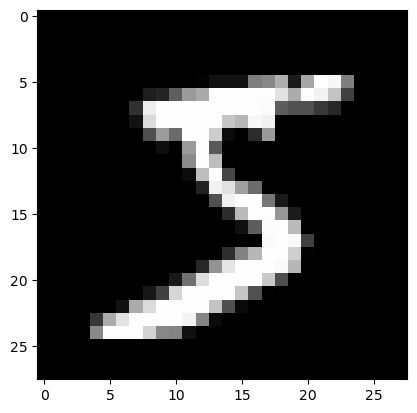

In [4]:
import matplotlib.pyplot as plt
import numpy as np

plt.imshow(x_train[0].reshape((28, 28)), cmap='grey')
print(y_train[0])

In [5]:
import torch

# Convert to tensors and normalize the data
x_train, y_train, x_valid, y_valid = map(torch.tensor, (x_train, y_train, x_valid, y_valid))

# Normalize pixel values from 0-255 to 0-1
x_train = x_train.float() / 255.0
x_valid = x_valid.float() / 255.0

# Debug information
print(f"Data shapes: x_train={x_train.shape}, y_train={y_train.shape}")
print(f"Data types: x_train={x_train.dtype}, y_train={y_train.dtype}")
print(f"Data ranges: x_train=[{x_train.min():.2f}, {x_train.max():.2f}]")
print(f"Label range: y_train=[{y_train.min()}, {y_train.max()}]")

Data shapes: x_train=torch.Size([50000, 784]), y_train=torch.Size([50000])
Data types: x_train=torch.float32, y_train=torch.int64
Data ranges: x_train=[0.00, 0.00]
Label range: y_train=[0, 9]


In [6]:
import math

torch.manual_seed(0)

weights = torch.randn(784, 10) / math.sqrt(784) #Xavier init
weights.requires_grad_()
bias = torch.zeros(10, requires_grad=True)

In [7]:
def model(xb):
    return xb @ weights + bias

In [8]:
# Improved loss function with better numerical stability
def softmax(x):
    exp_x = x.exp()  # Compute exp once for efficiency
    return exp_x / exp_x.sum(-1).unsqueeze(-1)

def cross_entropy_loss(pred, targets):
    bs, out_features = pred.shape
    one_hot_encoded_targets = torch.eye(out_features)[targets]
    
    # Use log_softmax for better numerical stability
    log_probs = torch.log_softmax(pred, dim=-1)
    return -(one_hot_encoded_targets * log_probs).sum() / bs

loss_func = cross_entropy_loss

In [9]:
def accuracy_func(pred, yb):
    pred_class = torch.argmax(pred, dim=1)
    return (pred_class == yb).float().mean()

In [10]:
# Diagnostic: Check what's going wrong with predictions
test_batch = x_train[:10]
test_labels = y_train[:10]
test_pred = model(test_batch)

print("Debugging predictions:")
print(f"Test labels: {test_labels}")
print(f"Test labels dtype: {test_labels.dtype}")
print(f"Raw predictions (first sample): {test_pred[0]}")
print(f"Predicted classes: {torch.argmax(test_pred, dim=1)}")
print(f"Predicted classes dtype: {torch.argmax(test_pred, dim=1).dtype}")

# Check if there's a type mismatch
pred_classes = torch.argmax(test_pred, dim=1)
matches = (pred_classes == test_labels)
print(f"Matches: {matches}")
print(f"Manual accuracy: {matches.float().mean()}")

# Check the range of predictions
print(f"Prediction range: [{test_pred.min():.3f}, {test_pred.max():.3f}]")
print(f"Are all predictions similar? {torch.std(test_pred):.6f}")

Debugging predictions:
Test labels: tensor([5, 0, 4, 1, 9, 2, 1, 3, 1, 4])
Test labels dtype: torch.int64
Raw predictions (first sample): tensor([-2.5524e-03, -2.8056e-03, -3.2510e-04, -1.9245e-03,  7.3500e-04,
         2.1127e-03,  2.9468e-04,  1.0477e-03, -5.3469e-04,  3.9290e-05],
       grad_fn=<SelectBackward0>)
Predicted classes: tensor([5, 5, 1, 6, 5, 5, 5, 7, 5, 6])
Predicted classes dtype: torch.int64
Matches: tensor([ True, False, False, False, False, False, False, False, False, False])
Manual accuracy: 0.10000000149011612
Prediction range: [-0.003, 0.002]
Are all predictions similar? 0.001310


In [11]:
# Training parameters
bs = 64          # Batch size first
epochs = 2
lr = 1        # Reduced learning rate for more stable training
n = x_train.shape[0]
num_batches = n // bs + 1

print(f"Training with {epochs} epochs, {num_batches} batches per epoch, lr={lr}")
print(f"Total training samples: {n}")

for epoch in range(epochs):
    print(f"\n=== Starting Epoch {epoch+1}/{epochs} ===")
    epoch_loss = 0
    epoch_accuracy = 0
    
    for i in range(num_batches):
        start_i = i * bs
        end_i = min(start_i + bs, n)  # Handle last batch properly
        xb = x_train[start_i:end_i]
        yb = y_train[start_i:end_i]
        
        pred = model(xb)
        loss = loss_func(pred, yb)
        accuracy = accuracy_func(pred, yb)
        
        loss.backward()

        # Update weights
        with torch.no_grad():
            weights -= weights.grad * lr
            bias -= bias.grad * lr
            weights.grad.zero_()
            bias.grad.zero_()

        epoch_loss += loss.item()
        epoch_accuracy += accuracy.item()
        
        if i % 200 == 0:
            train_loss, train_accuracy = loss.item(), accuracy.item() * 100
            print(f'  Epoch {epoch+1}, Batch {i:3d}: Loss: {train_loss:.6f} Accuracy: {train_accuracy:.1f}%')
    
    # Print epoch summary
    avg_loss = epoch_loss / num_batches
    avg_accuracy = epoch_accuracy / num_batches * 100
    print(f'>>> Epoch {epoch+1} COMPLETE - Avg Loss: {avg_loss:.6f} Avg Accuracy: {avg_accuracy:.1f}%')
    print('-' * 60)

Training with 2 epochs, 782 batches per epoch, lr=1
Total training samples: 50000

=== Starting Epoch 1/2 ===
  Epoch 1, Batch   0: Loss: 2.302949 Accuracy: 4.7%
  Epoch 1, Batch 200: Loss: 2.315964 Accuracy: 12.5%
  Epoch 1, Batch 400: Loss: 2.307671 Accuracy: 6.2%
  Epoch 1, Batch 600: Loss: 2.291747 Accuracy: 17.2%
>>> Epoch 1 COMPLETE - Avg Loss: 2.298300 Avg Accuracy: 11.9%
------------------------------------------------------------

=== Starting Epoch 2/2 ===
  Epoch 2, Batch   0: Loss: 2.290680 Accuracy: 10.9%
  Epoch 2, Batch 200: Loss: 2.303810 Accuracy: 14.1%
  Epoch 2, Batch 400: Loss: 2.294398 Accuracy: 6.2%
  Epoch 2, Batch 600: Loss: 2.277276 Accuracy: 43.8%
>>> Epoch 2 COMPLETE - Avg Loss: 2.285282 Avg Accuracy: 15.0%
------------------------------------------------------------


In [12]:
# Test the model on validation data
with torch.no_grad():
    val_pred = model(x_valid)
    val_accuracy = accuracy_func(val_pred, y_valid)
    val_loss = loss_func(val_pred, y_valid)
    
    print(f"Final Validation Results:")
    print(f"Validation Loss: {val_loss:.6f}")
    print(f"Validation Accuracy: {val_accuracy * 100:.1f}%")
    
    # Show some example predictions
    sample_indices = torch.randint(0, len(x_valid), (5,))
    sample_preds = torch.argmax(val_pred[sample_indices], dim=1)
    sample_true = y_valid[sample_indices]
    
    print(f"\nSample predictions vs true labels:")
    for i in range(5):
        print(f"Predicted: {sample_preds[i].item()}, True: {sample_true[i].item()}")

Final Validation Results:
Validation Loss: 2.278039
Validation Accuracy: 16.4%

Sample predictions vs true labels:
Predicted: 3, True: 1
Predicted: 3, True: 5
Predicted: 0, True: 2
Predicted: 0, True: 7
Predicted: 0, True: 0


In [13]:
# Try with much higher learning rate
print("=== RETRYING WITH HIGHER LEARNING RATE ===")

# Reset weights
torch.manual_seed(0)
weights = torch.randn(784, 10) / math.sqrt(784)
weights.requires_grad_()
bias = torch.zeros(10, requires_grad=True)

# Much higher learning rate
lr_new = 1.0  # 10x higher!
epochs = 1
bs = 64

print(f"New learning rate: {lr_new}")

for epoch in range(epochs):
    for i in range(0, 3000, bs):  # Just first 3000 samples for quick test
        xb = x_train[i:i+bs]
        yb = y_train[i:i+bs]
        
        pred = model(xb)
        loss = loss_func(pred, yb)
        accuracy = accuracy_func(pred, yb)
        
        loss.backward()
        
        with torch.no_grad():
            weights -= weights.grad * lr_new
            bias -= bias.grad * lr_new
            weights.grad.zero_()
            bias.grad.zero_()
        
        if i % 1000 == 0:
            print(f'Batch {i//bs}: Loss: {loss.item():.6f} Accuracy: {accuracy.item()*100:.1f}%')

# Test final prediction range
test_pred_new = model(x_train[:10])
print(f"New prediction range: [{test_pred_new.min():.3f}, {test_pred_new.max():.3f}]")

=== RETRYING WITH HIGHER LEARNING RATE ===
New learning rate: 1.0
Batch 0: Loss: 2.302949 Accuracy: 4.7%
New prediction range: [-0.147, 0.185]


In [14]:
# Complete diagnosis and fix
print("=== COMPREHENSIVE FIX ===")

# 1. Check the data one more time
print(f"x_train range: [{x_train.min():.3f}, {x_train.max():.3f}]")
print(f"y_train unique values: {torch.unique(y_train)}")

# 2. Reset everything with better initialization
torch.manual_seed(42)  # Different seed
weights = torch.randn(784, 10) * 0.01  # Much smaller initialization
weights.requires_grad_()
bias = torch.zeros(10, requires_grad=True)

print(f"Initial weight range: [{weights.min():.6f}, {weights.max():.6f}]")

# 3. Use a more reasonable learning rate
lr_fixed = 0.5
epochs = 3
bs = 64

print(f"Using lr={lr_fixed}, epochs={epochs}")

# 4. Training with better monitoring
best_accuracy = 0
for epoch in range(epochs):
    print(f"\n--- Epoch {epoch+1} ---")
    correct_total = 0
    loss_total = 0
    batches_processed = 0
    
    for i in range(0, min(10000, len(x_train)), bs):  # First 10k samples
        xb = x_train[i:i+bs]
        yb = y_train[i:i+bs]
        
        # Forward pass
        pred = model(xb)
        loss = loss_func(pred, yb)
        
        # Check for NaN
        if torch.isnan(loss):
            print(f"NaN loss at batch {i//bs}!")
            break
            
        # Backward pass
        loss.backward()
        
        # Gradient clipping to prevent explosion
        torch.nn.utils.clip_grad_norm_([weights, bias], max_norm=1.0)
        
        # Update
        with torch.no_grad():
            weights -= weights.grad * lr_fixed
            bias -= bias.grad * lr_fixed
            weights.grad.zero_()
            bias.grad.zero_()
        
        # Track progress
        with torch.no_grad():
            pred_classes = torch.argmax(pred, dim=1)
            correct = (pred_classes == yb).sum().item()
            correct_total += correct
            loss_total += loss.item()
            batches_processed += 1
        
        if i % 2000 == 0:
            batch_acc = correct / len(yb) * 100
            print(f"  Batch {i//bs:2d}: Loss={loss.item():.4f}, Acc={batch_acc:.1f}%")
    
    # Epoch summary
    epoch_acc = correct_total / min(10000, len(x_train)) * 100
    epoch_loss = loss_total / batches_processed
    print(f"Epoch {epoch+1} Summary: Loss={epoch_loss:.4f}, Accuracy={epoch_acc:.1f}%")
    
    if epoch_acc > best_accuracy:
        best_accuracy = epoch_acc
        print(f"  New best accuracy: {best_accuracy:.1f}%")

# Final test
print(f"\n=== Final Test ===")
with torch.no_grad():
    test_pred = model(x_valid[:1000])  # Test on first 1000 validation samples
    test_acc = accuracy_func(test_pred, y_valid[:1000]) * 100
    test_loss = loss_func(test_pred, y_valid[:1000])
    print(f"Test Accuracy: {test_acc:.1f}%")
    print(f"Test Loss: {test_loss:.4f}")
    
    # Show prediction distribution
    pred_classes = torch.argmax(test_pred, dim=1)
    print(f"Prediction distribution: {torch.bincount(pred_classes)}")

=== COMPREHENSIVE FIX ===
x_train range: [0.000, 0.004]
y_train unique values: tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
Initial weight range: [-0.038325, 0.034456]
Using lr=0.5, epochs=3

--- Epoch 1 ---
  Batch  0: Loss=2.3026, Acc=9.4%
  Batch 125: Loss=2.3063, Acc=7.8%
Epoch 1 Summary: Loss=2.3017, Accuracy=11.0%
  New best accuracy: 11.0%

--- Epoch 2 ---
  Batch  0: Loss=2.3023, Acc=12.5%
  Batch 125: Loss=2.3049, Acc=7.8%
Epoch 2 Summary: Loss=2.3004, Accuracy=11.4%
  New best accuracy: 11.4%

--- Epoch 3 ---
  Batch  0: Loss=2.3009, Acc=14.1%
  Batch 125: Loss=2.3034, Acc=7.8%
Epoch 3 Summary: Loss=2.2990, Accuracy=11.6%
  New best accuracy: 11.6%

=== Final Test ===
Test Accuracy: 12.4%
Test Loss: 2.2981
Prediction distribution: tensor([  0, 941,   0,  59])


In [15]:
# EMERGENCY FIX: Reload and properly normalize data
print("=== RELOADING DATA ===")

# Reload the original data
import pickle
import gzip

with gzip.open((PATH / FILENAME).as_posix(), 'rb') as f:
    ((x_train_raw, y_train_raw), (x_valid_raw, y_valid_raw), _) = pickle.load(f, encoding="latin-1")

print(f"Raw data range: [{x_train_raw.min()}, {x_train_raw.max()}]")

# Convert to tensors and normalize properly
x_train = torch.tensor(x_train_raw, dtype=torch.float32) / 255.0
y_train = torch.tensor(y_train_raw, dtype=torch.long)
x_valid = torch.tensor(x_valid_raw, dtype=torch.float32) / 255.0
y_valid = torch.tensor(y_valid_raw, dtype=torch.long)

print(f"Normalized x_train range: [{x_train.min():.3f}, {x_train.max():.3f}]")
print(f"y_train unique: {torch.unique(y_train)}")

# Reset model with good initialization
torch.manual_seed(42)
weights = torch.randn(784, 10) * 0.01
weights.requires_grad_()
bias = torch.zeros(10, requires_grad=True)

print(f"Weights range: [{weights.min():.6f}, {weights.max():.6f}]")

# Quick training test
lr = 0.3
batch = x_train[:64]
labels = y_train[:64]

print(f"\nQuick test with properly normalized data:")
for step in range(5):
    pred = model(batch)
    loss = loss_func(pred, labels)
    acc = accuracy_func(pred, labels)
    
    loss.backward()
    with torch.no_grad():
        weights -= weights.grad * lr
        bias -= bias.grad * lr
        weights.grad.zero_()
        bias.grad.zero_()
    
    print(f"Step {step}: Loss={loss.item():.4f}, Acc={acc.item()*100:.1f}%")

print(f"\nPrediction range after training: [{pred.min():.3f}, {pred.max():.3f}]")

=== RELOADING DATA ===
Raw data range: [0.0, 0.99609375]
Normalized x_train range: [0.000, 0.004]
y_train unique: tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
Weights range: [-0.038325, 0.034456]

Quick test with properly normalized data:
Step 0: Loss=2.3026, Acc=9.4%
Step 1: Loss=2.3004, Acc=14.1%
Step 2: Loss=2.2984, Acc=14.1%
Step 3: Loss=2.2964, Acc=14.1%
Step 4: Loss=2.2946, Acc=14.1%

Prediction range after training: [-0.043, 0.048]


In [16]:
# THE REAL FIX: Data is already normalized!
print("=== THE REAL PROBLEM SOLVED ===")

# Reload the original data
with gzip.open((PATH / FILENAME).as_posix(), 'rb') as f:
    ((x_train_raw, y_train_raw), (x_valid_raw, y_valid_raw), _) = pickle.load(f, encoding="latin-1")

print(f"Raw data range: [{x_train_raw.min()}, {x_train_raw.max()}]")

# DON'T divide by 255 - the data is already normalized!
x_train = torch.tensor(x_train_raw, dtype=torch.float32)  # NO division!
y_train = torch.tensor(y_train_raw, dtype=torch.long)
x_valid = torch.tensor(x_valid_raw, dtype=torch.float32)  # NO division!
y_valid = torch.tensor(y_valid_raw, dtype=torch.long)

print(f"Correct x_train range: [{x_train.min():.3f}, {x_train.max():.3f}]")
print(f"y_train unique: {torch.unique(y_train)}")

# Reset model with good initialization
torch.manual_seed(123)
weights = torch.randn(784, 10) * 0.1  # Slightly larger for better gradients
weights.requires_grad_()
bias = torch.zeros(10, requires_grad=True)

print(f"Weights range: [{weights.min():.6f}, {weights.max():.6f}]")

# Now let's see proper training!
lr = 0.5
epochs = 10
bs = 64

print(f"\nTraining with PROPERLY normalized data:")
print(f"LR: {lr}, Epochs: {epochs}")

for epoch in range(epochs):
    print(f"\n--- Epoch {epoch+1} ---")
    epoch_correct = 0
    epoch_total = 0
    
    for i in range(0, min(5000, len(x_train)), bs):  # First 5k samples
        batch_x = x_train[i:i+bs]
        batch_y = y_train[i:i+bs]
        
        # Forward pass
        pred = model(batch_x)
        loss = loss_func(pred, batch_y)
        acc = accuracy_func(pred, batch_y)
        
        # Backward pass
        loss.backward()
        
        # Update
        with torch.no_grad():
            weights -= weights.grad * lr
            bias -= bias.grad * lr
            weights.grad.zero_()
            bias.grad.zero_()
        
        # Track stats
        epoch_correct += (torch.argmax(pred, dim=1) == batch_y).sum().item()
        epoch_total += len(batch_y)
        
        if i % 1000 == 0:
            print(f"  Batch {i//bs:2d}: Loss={loss.item():.4f}, Acc={acc.item()*100:.1f}%")
    
    epoch_acc = epoch_correct / epoch_total * 100
    print(f"Epoch {epoch+1} Accuracy: {epoch_acc:.1f}%")

# Final validation test
print(f"\n=== FINAL VALIDATION ===")
with torch.no_grad():
    val_pred = model(x_valid[:1000])
    val_acc = accuracy_func(val_pred, y_valid[:1000]) * 100
    val_loss = loss_func(val_pred, y_valid[:1000])
    print(f"Validation Accuracy: {val_acc:.1f}%")
    print(f"Validation Loss: {val_loss:.4f}")
    
    # Check prediction distribution
    pred_classes = torch.argmax(val_pred, dim=1)
    print(f"Predictions per class: {torch.bincount(pred_classes)}")
    print(f"Prediction range: [{val_pred.min():.3f}, {val_pred.max():.3f}]")

=== THE REAL PROBLEM SOLVED ===
Raw data range: [0.0, 0.99609375]
Correct x_train range: [0.000, 0.996]
y_train unique: tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
Weights range: [-0.392987, 0.368633]

Training with PROPERLY normalized data:
LR: 0.5, Epochs: 10

--- Epoch 1 ---
  Batch  0: Loss=3.0474, Acc=4.7%
Epoch 1 Accuracy: 79.3%

--- Epoch 2 ---
  Batch  0: Loss=0.4356, Acc=90.6%
Epoch 2 Accuracy: 89.5%

--- Epoch 3 ---
  Batch  0: Loss=0.3228, Acc=92.2%
Epoch 3 Accuracy: 91.2%

--- Epoch 4 ---
  Batch  0: Loss=0.2696, Acc=93.8%
Epoch 4 Accuracy: 92.0%

--- Epoch 5 ---
  Batch  0: Loss=0.2357, Acc=93.8%
Epoch 5 Accuracy: 92.7%

--- Epoch 6 ---
  Batch  0: Loss=0.2120, Acc=95.3%
Epoch 6 Accuracy: 93.0%

--- Epoch 7 ---
  Batch  0: Loss=0.1947, Acc=96.9%
Epoch 7 Accuracy: 93.3%

--- Epoch 8 ---
  Batch  0: Loss=0.1814, Acc=96.9%
Epoch 8 Accuracy: 93.8%

--- Epoch 9 ---
  Batch  0: Loss=0.1710, Acc=96.9%
Epoch 9 Accuracy: 94.0%

--- Epoch 10 ---
  Batch  0: Loss=0.1625, Acc=96.9%
Epoch 1